In [1]:
import sys
sys.path.append('..')

import cv2

import numpy as np
import matplotlib.pyplot as plt
from src.classical_tracker import ClassicalTracker
import importlib
import src.deep_tracker
importlib.reload(src.deep_tracker)
from src.deep_tracker import DeepTracker
import torch
from pathlib import Path

VIDEO_PATH_MUG = '../Test-Videos/Antoine_Mug.mp4'
VIDEO_PATH_BALL='../Test-Videos/VOT-ball.mp4'
VIDEO_PATH_BASKET = '../Test-Videos/VOT-Basket.mp4'
VIDEO_PATH_CAR='../Test-Videos/VOT-Car.mp4'
VIDEO_PATH_SUNSHADE='../Test-Videos/VOT-Sunshade.mp4'
VIDEO_PATH_WOMAN='../Test-Videos/VOT-Woman.mp4'
device = 'msg' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Run multiple methods interactively (one by one)
# For each method you'll be able to select ROI on the first frame and then
# the tracker will run and save results to ../results/evaluation/{method}_mug

methods_to_run = [
    {'name': 'meanshift_hue', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hue'},
    {'name': 'meanshift_hsv', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hsv'},
    {'name': 'adaptive_hue', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hue', 'update_model': True, 'update_rate': 0.1},
    # {'name': 'hough_basic', 'kind': 'classical', 'method': 'hough'},
    # {'name': 'predictive_hough', 'kind': 'classical', 'method': 'predictive_hough'},
    {'name': 'deep_meanshift', 'kind': 'deep', 'model_name': 'resnet50', 'layer_name': 'layer3', 'top_k_channels': 64},
]

for m in methods_to_run:
    exp_name = f"{m['name']}_mug"
    out_dir = Path(f"../results/evaluation/{exp_name}")
    out_dir.mkdir(parents=True, exist_ok=True)
    print('\n' + '='*60)
    print(f"Starting interactive run for: {m['name']}\nResults will be saved to: {out_dir}")
    print("Instructions: select ROI on the first frame, press SPACE/ENTER to confirm. During tracking press ESC to stop, 's' to save frame.")

    try:
        if m['kind'] == 'classical':
            tr = ClassicalTracker(
                video_path=VIDEO_PATH_MUG,
                method=m.get('method','meanshift'),
                color_space=m.get('color_space','hsv'),
                update_model=m.get('update_model', False),
                update_rate=m.get('update_rate', 0.05),
            )
            tr.track_video(visualize=True, visualize_process=True,  
                            save_result=True,output_dir=str(out_dir))

        elif m['kind'] == 'deep':
            tr = DeepTracker(
                video_path=VIDEO_PATH_MUG,
                model_name=m.get('model_name','resnet50'),
                layer_name=m.get('layer_name','layer3'),
                top_k_channels=m.get('top_k_channels',64),
                device=device if 'device' in globals() else 'cpu'
            )
            tr.track_video(visualize=True, visualize_process=True,  
                            save_result=True, output_dir=str(out_dir))

        else:
            print('Unknown method kind:', m)

    except Exception as e:
        print(f"Error running {m['name']}: {e}")
        continue

print('\nAll interactive runs completed.')



Starting interactive run for: meanshift_hue
Results will be saved to: ../results/evaluation/meanshift_hue_mug
Instructions: select ROI on the first frame, press SPACE/ENTER to confirm. During tracking press ESC to stop, 's' to save frame.
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 220

Starting interactive run for: meanshift_hsv
Results will be saved to: ../results/evaluation/meanshift_hsv_mug
Instructions: select ROI on the first frame, press SPACE/ENTER to confirm. During tracking press ESC to stop, 's' to save frame.
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit
Error running meanshift_hsv: OpenCV(4.11.

### 对比展示（按帧）

下面的代码会读取 `results/evaluation/*_mug/Frame_*.png`（若缺失会尝试用 `predictions.csv` + `VIDEO_PATH_MUG` 从视频帧绘制框作退路），并为每个指定的帧生成一张横向对比图（每列一个方法）。

- 编辑 `methods` 列表选择你想对比的方法目录（默认会自动发现）。
- 编辑 `frames_to_show` 选择要展示的帧编号（与 `Frame_0001.png` 的编号对应）。
- 输出会显示在 notebook 中，并保存到 `results/evaluation/comparison_frames/`。


Found method directories: ['meanshift_hue_mug', 'adaptive_hue_mug']
Looking for frame image at: ../results/evaluation/meanshift_hue_mug/process/BackProj_0001.png
Looking for frame image at: ../results/evaluation/meanshift_hue_mug/process/BackProj_0031.png
Looking for frame image at: ../results/evaluation/meanshift_hue_mug/process/BackProj_0081.png
Looking for frame image at: ../results/evaluation/meanshift_hue_mug/process/BackProj_0151.png
Looking for frame image at: ../results/evaluation/meanshift_hue_mug/process/BackProj_0201.png


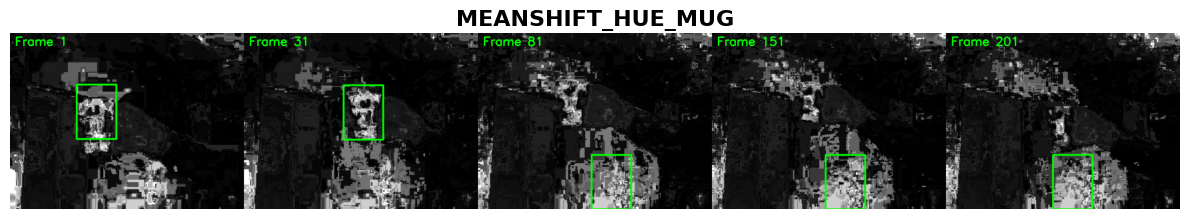

Saved montage for meanshift_hue_mug -> ../results/evaluation/comparison_frames/process/meanshift_hue_mug_frames.png
Looking for frame image at: ../results/evaluation/adaptive_hue_mug/process/BackProj_0001.png
Looking for frame image at: ../results/evaluation/adaptive_hue_mug/process/BackProj_0031.png
Looking for frame image at: ../results/evaluation/adaptive_hue_mug/process/BackProj_0081.png
Looking for frame image at: ../results/evaluation/adaptive_hue_mug/process/BackProj_0151.png
Looking for frame image at: ../results/evaluation/adaptive_hue_mug/process/BackProj_0201.png


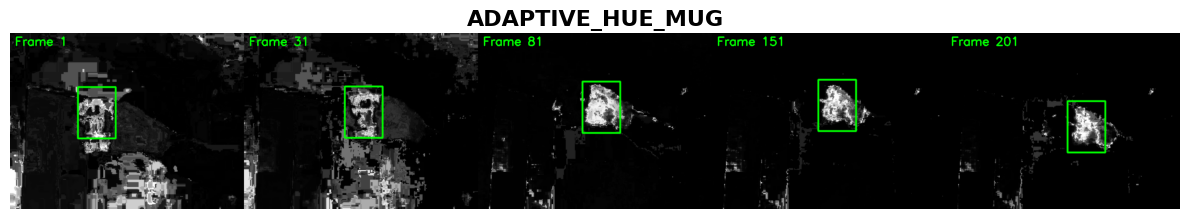

Saved montage for adaptive_hue_mug -> ../results/evaluation/comparison_frames/process/adaptive_hue_mug_frames.png


In [ ]:
# Cell: 为每个方法生成多帧展示（每方法一行/一图）
from pathlib import Path
import glob, os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 配置（按需修改）
ROOT = Path('../results/evaluation')
OUT = ROOT / 'comparison_frames/process'
OUT.mkdir(parents=True, exist_ok=True)

# 自动发现含 Frame_*.png 的方法目录；若想手动指定，把 auto=False 并写 methods 列表
auto = False
if not auto:
    methods = [
        'meanshift_hue_mug',
        'adaptive_hue_mug',
        # 'hough_basic_mug',
        # 'predictive_hough_mug',
        # 'deep_meanshift_mug',
    ]
else:
    methods = []
    for p in sorted(ROOT.iterdir()):
        if p.is_dir() and any(p.glob('BcakProj_*.png')):
            methods.append(p.name)

print('Found method directories:', methods)

# 要展示的帧编号（与 Frame_XXXX 编号对应）
frames_to_show = [1, 31, 81,151, 201]

# 回退 video path（当没有 Frame_*.png 时，用 predictions.csv 在视频上绘框）
VIDEO_FALLBACK = globals().get('VIDEO_PATH_MUG', '../Test-Videos/Antoine_Mug.mp4')

# helper: 读取帧或回退绘制
def read_frame_image(method_dir, frame_idx, target_size=None):
    process = ROOT / method_dir / 'process'
    p = process/ f'BackProj_{frame_idx:04d}.png'
    print('Looking for frame image at:', p)
    if p.exists():
        im = cv2.imread(str(p))
        if im is not None:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            if target_size is not None:
                im = cv2.resize(im, target_size)
            return im
    # 回退：用 predictions.csv + 视频绘制
    pred_csv = ROOT / method_dir / 'predictions.csv'
    if pred_csv.exists() and os.path.exists(VIDEO_FALLBACK):
        try:
            df = pd.read_csv(pred_csv).set_index('frame')
            if frame_idx in df.index:
                cap = cv2.VideoCapture(VIDEO_FALLBACK)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx - 1)
                ret, frame = cap.read()
                cap.release()
                if ret:
                    x = int(df.loc[frame_idx, 'x'])
                    y = int(df.loc[frame_idx, 'y'])
                    w = int(df.loc[frame_idx, 'w'])
                    h = int(df.loc[frame_idx, 'h'])
                    bgr = frame.copy()
                    cv2.rectangle(bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    im = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                    if target_size is not None:
                        im = cv2.resize(im, target_size)
                    return im
        except Exception:
            pass
    # 最后回退空白
    if target_size is None:
        return np.zeros((360, 640, 3), dtype=np.uint8)
    else:
        return np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

# 为每个方法生成一张包含多个帧的横向对比图并保存
for m in methods:
    imgs = []
    for fid in frames_to_show:
        im = read_frame_image(m, fid)
        imgs.append(im)
    # 统一尺寸：以第一个有效图像为参考
    ref = next((im for im in imgs if im is not None), None)
    if ref is None:
        print('No images for', m)
        continue
    H, W = ref.shape[:2]
    # resize all to same H (preserve aspect by scaling width proportionally)
    resized = []
    target_h = 360
    for im in imgs:
        if im is None:
            im2 = np.zeros((target_h, int(target_h * W / H), 3), dtype=np.uint8)
        else:
            h0, w0 = im.shape[:2]
            scale = target_h / float(h0)
            w_new = int(round(w0 * scale))
            im2 = cv2.resize(im, (w_new, target_h))
        resized.append(im2)
    # 拼接横向
    total_w = sum(im.shape[1] for im in resized)
    canvas = np.zeros((target_h, total_w, 3), dtype=np.uint8)
    x = 0
    for im in resized:
        w = im.shape[1]
        canvas[:, x:x+w] = im
        x += w
    # 绘制标注（帧号）在图上
    canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    x = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    for im, fid in zip(resized, frames_to_show):
        w = im.shape[1]
        cv2.putText(canvas_bgr, f'Frame {fid}', (x + 10, 25), font, 0.8, (0,255,0), 2)
        x += w
    canvas_rgb = cv2.cvtColor(canvas_bgr, cv2.COLOR_BGR2RGB)
    # 保存并展示
    out_path = OUT / f'{m}_frames.png'
    plt.figure(figsize=(12,4))
    # Title: uppercase and bold
    plt.title(m.upper(), fontsize=16, fontweight='bold')
    plt.imshow(canvas_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(str(out_path), bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    print('Saved montage for', m, '->', out_path)
